<a href="https://colab.research.google.com/github/karasu1982/colab_notebook/blob/main/202510_%E5%B0%8F%E5%A3%B2%E6%A5%AD%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E5%A3%B2%E4%B8%8A%E4%BA%88%E6%B8%AC%E7%B2%BE%E5%BA%A6%E5%90%91%E4%B8%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, lightgbm as lgb, optuna, warnings
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import holidays, datetime

warnings.filterwarnings("ignore")

In [ ]:
# ========================================
# データ取得 (UCI Online Retail)
# ========================================
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(UCI_URL)

# 基本整形
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df['Quantity']*df['UnitPrice']
df['date'] = df['InvoiceDate'].dt.date
df = df.groupby('date',as_index=False)['Sales'].sum()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.set_index('date').asfreq('D').fillna(0)
df.head()

,Sales
date,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95


In [ ]:
# ========================================
# 学習・検証期間の設定
# ========================================
train_ratio = 0.8
split_point = int(len(df)*train_ratio)
train, test = df.iloc[:split_point], df.iloc[split_point:]
print(f"Train: {train.index.min()} ~ {train.index.max()} ({len(train)}日)")
print(f"Test:  {test.index.min()} ~ {test.index.max()} ({len(test)}日)")

Train: 2010-12-01 00:00:00 ~ 2011-09-25 00:00:00 (299日)
Test:  2011-09-26 00:00:00 ~ 2011-12-09 00:00:00 (75日)


In [ ]:
# ========================================
# 1) LightGBM (特徴量＋Optuna最適化)
# ========================================
def create_features(data):
    out = data.copy()
    out['dayofweek'] = out.index.dayofweek
    out['month'] = out.index.month
    out['lag1'] = out['Sales'].shift(1)
    out['lag7'] = out['Sales'].shift(7)
    out['roll7'] = out['Sales'].rolling(7).mean()
    out['roll30'] = out['Sales'].rolling(30).mean()
    return out.dropna()

train_feat = create_features(train)
test_feat  = create_features(pd.concat([train.tail(30),test]))


def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/(y_true+1e-9)))

X_train, y_train = train_feat.drop(columns=['Sales']), train_feat['Sales']
X_test, y_test_lgb   = test_feat.drop(columns=['Sales']), test_feat['Sales']

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate",0.01,0.2,log=True),
        "num_leaves": trial.suggest_int("num_leaves",31,255),
        "feature_fraction": trial.suggest_float("feature_fraction",0.6,1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction",0.6,1.0),
        "bagging_freq": trial.suggest_int("bagging_freq",0,7),
        "lambda_l1": trial.suggest_float("lambda_l1",0.0,5.0),
        "lambda_l2": trial.suggest_float("lambda_l2",0.0,5.0),
        "verbosity": -1
    }
    model = lgb.train(params,lgb.Dataset(X_train,label=y_train),num_boost_round=1000,
                      callbacks=[lgb.log_evaluation(period=100)])

    y_pred = model.predict(X_test)
    return mape(y_test_lgb,y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best params:", study.best_params)

[I 2025-10-07 01:22:55,090] A new study created in memory with name: no-name-121e63ab-ccfb-441e-ab3b-9baff32a1cec
[I 2025-10-07 01:22:55,270] Trial 0 finished with value: 1012120754749.7848 and parameters: {'learning_rate': 0.01094979232559769, 'num_leaves': 197, 'feature_fraction': 0.6565556117486239, 'bagging_fraction': 0.8311488067514679, 'bagging_freq': 7, 'lambda_l1': 0.8649296382615862, 'lambda_l2': 0.7593864069354456}. Best is trial 0 with value: 1012120754749.7848.
[I 2025-10-07 01:22:55,447] Trial 1 finished with value: 994891605382.5765 and parameters: {'learning_rate': 0.012955918120043822, 'num_leaves': 156, 'feature_fraction': 0.663676968694388, 'bagging_fraction': 0.831632690618401, 'bagging_freq': 4, 'lambda_l1': 3.1148417147955, 'lambda_l2': 3.0645259811241408}. Best is trial 1 with value: 994891605382.5765.
[I 2025-10-07 01:22:55,622] Trial 2 finished with value: 868641370714.0673 and parameters: {'learning_rate': 0.08145599869801887, 'num_leaves': 105, 'feature_fracti

Best params: {'learning_rate': 0.021941937121137147, 'num_leaves': 110, 'feature_fraction': 0.713553325685313, 'bagging_fraction': 0.9225576355331268, 'bagging_freq': 2, 'lambda_l1': 0.7994879759209397, 'lambda_l2': 1.3677323244853128}


In [ ]:
# LightGBM最終モデルと予測
best_params = study.best_params
model_lgb = lgb.train({**best_params, "objective":"regression","metric":"mae","verbosity":-1},
                      lgb.Dataset(X_train,label=y_train),num_boost_round=1000)
pred_lgb = model_lgb.predict(X_test)


In [ ]:
# ========================================
# 2) ARIMA (statsmodels SARIMAX 版) - AICでグリッド探索
# ========================================
import warnings
warnings.filterwarnings("ignore")

import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_train = train['Sales'].astype('float64')
y_test  = test['Sales'].astype('float64')

# 探索レンジ（軽量寄り。遅い/収束しにくい時は縮めてOK）
p = d = q = range(0, 4)       # ARIMA(p,d,q)
P = D = Q = range(0, 3)       # Seasonal(P,D,Q,s)
s = 7                         # 週期（デイリーなので7が自然。季節性不要なら s=None に）

pdq = list(itertools.product(p, [0,1,2], q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, [0,1], Q)]

best_aic = np.inf
best_order = None
best_seasonal = None

def fit_sarimax(endog, order, seasonal_order=None):
    if seasonal_order is not None:
        model = SARIMAX(endog,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
    else:
        model = SARIMAX(endog,
                        order=order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
    return model.fit(disp=False)

print("Searching SARIMAX orders (this can take a few minutes)...")
for order in pdq:
    for seas in seasonal_pdq:
        try:
            res = fit_sarimax(y_train, order, seas)
            aic = res.aic
            if aic < best_aic and np.isfinite(aic):
                best_aic = aic
                best_order = order
                best_seasonal = seas
        except Exception as e:
            # 収束しない/特異行列などはスキップ
            continue

print(f"Best AIC: {best_aic:.2f}")
print(f"Best order: ARIMA{best_order}, seasonal={best_seasonal}")

# ベスト設定で最学習
model_arima_sm = fit_sarimax(y_train, best_order, best_seasonal)
pred_arima = model_arima_sm.forecast(steps=len(y_test)).values


Searching SARIMAX orders (this can take a few minutes)...
Best AIC: 5972.15
Best order: ARIMA(3, 1, 3), seasonal=(2, 1, 2, 7)


In [ ]:
# ========================================
# 3) Prophet モデル
# ========================================
prophet_df = train.reset_index().rename(columns={'date':'ds','Sales':'y'})
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)
pred_prophet = forecast.set_index('ds').loc[test.index]['yhat'].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8ii9dvy/hot916y2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8ii9dvy/j1ydns0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7936', 'data', 'file=/tmp/tmpx8ii9dvy/hot916y2.json', 'init=/tmp/tmpx8ii9dvy/j1ydns0s.json', 'output', 'file=/tmp/tmpx8ii9dvy/prophet_model7yoyaxqz/prophet_model-20251007014535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,Model,MAE,RMSE,MAPE
0,LightGBM,15036.729108,23935.151814,7.681048e+11
1,ARIMA,18140.187005,25098.092676,3.310390e+12
2,Prophet,32456.344905,42078.477329,1.443091e+12


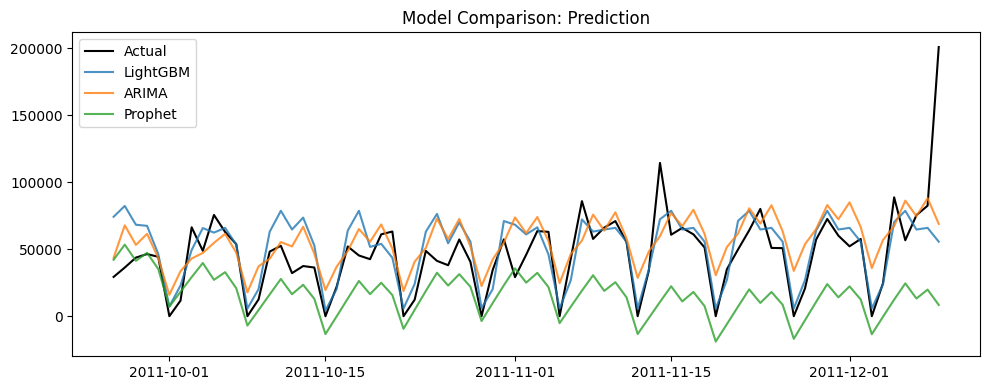

In [ ]:
# ========================================
# 4) 精度比較
# ========================================
def eval_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mp = mape(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "MAPE": mp}

y_true_eval = test['Sales']
pred_lgb_aligned = pd.Series(pred_lgb, index=X_test.index).loc[y_true_eval.index].values


results = pd.DataFrame([
    eval_metrics("LightGBM", y_true_eval, pred_lgb_aligned),
    eval_metrics("ARIMA", y_true_eval, pred_arima),
    eval_metrics("Prophet", y_true_eval, pred_prophet)
])
display(results)

plt.figure(figsize=(10,4))
plt.plot(test.index, y_true_eval, label="Actual", color="black")
plt.plot(test.index, pred_lgb_aligned, label="LightGBM", alpha=0.8)
plt.plot(test.index, pred_arima, label="ARIMA", alpha=0.8)
plt.plot(test.index, pred_prophet, label="Prophet", alpha=0.8)
plt.legend(); plt.title("Model Comparison: Prediction"); plt.tight_layout(); plt.show()